<a href="https://colab.research.google.com/github/BrutFab/ppo_BipedalWalker_v3/blob/main/ppo_BipedalWalker_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# original :  https://github.com/BrutFab/ppo_BipedalWalker_v3

# **1. Setup**


In [ ]:
# mount google drive

import os
from google.colab import drive
drive.mount('/content/drive')

video_dir = "/content/drive/MyDrive/ppo_final"
if not os.path.exists(video_dir):
    os.makedirs(video_dir)

Mounted at /content/drive


### **Install Packages**

In [ ]:
# Install necessary packages
!apt install swig cmake ffmpeg xvfb python3-opengl
!pip install stable-baselines3==2.0.0a5 gymnasium[box2d] huggingface_sb3 pyvirtualdisplay imageio[ffmpeg]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 swig4.0 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  libgle3 python3-numpy swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 python3-opengl swig swig4.0
  x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,755 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://

The Next Cell will force the notebook runtime to restart. This is to ensure all the new libraries installed will be used.

In [ ]:
import os
##os.kill(os.getpid(), 9)

### **Start Virtual Display**

In [ ]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

### **Setup Environment**

### **Observation Space**
Observation Space Shape (24,) vector of size 24, where each value contains different information about the walker:

- **Hull Angle Speed**: The speed at which the main body of the walker is rotating.
- **Angular Velocity**: The rate of change of the angular position of the walker.
- **Horizontal Speed**: The speed at which the walker is moving horizontally.
- **Vertical Speed**: The speed at which the walker is moving vertically.
- **Position of Joints**: The positions (angles) of the walker's joints. Given that the walker has 4 joints, this take up 4 values.
- **Joints Angular Speed**: The rate of change of the angular position for each joint. Again, this would be 4 values for the 4 joints.
- **Legs Contact with Ground**: Indicating whether each leg is in contact with the ground. Given two legs, this contains 2 values.
- **10 Lidar Rangefinder Measurements**: These are distance measurements to detect obstacles or terrain features around the walker. There are 10 of these values.


In [ ]:
import gymnasium as gym
##

env = gym.make("BipedalWalker-v3", hardcore=False)
env.reset()


(array([ 2.7474712e-03, -7.6440219e-06,  5.9462700e-04, -1.5999947e-02,
         9.2045233e-02, -7.8470557e-04,  8.6021996e-01,  1.9829841e-03,
         1.0000000e+00,  3.2449778e-02, -7.8464852e-04,  8.5377127e-01,
         5.5494910e-04,  1.0000000e+00,  4.4081402e-01,  4.4582012e-01,
         4.6142277e-01,  4.8955020e-01,  5.3410280e-01,  6.0246104e-01,
         7.0914888e-01,  8.8593185e-01,  1.0000000e+00,  1.0000000e+00],
       dtype=float32),
 {})

### **Action Space**

 Actions are motor speed values in the [-1, 1] range for each of the 4 joints at both hips and knees.

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.shape)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape (4,)
Action Space Sample [ 0.16420257  0.31622553 -0.48271242 -0.5036436 ]


### **Vectorized Environment**
Create a vectorized environment (a method for stacking multiple independent environments into a single environment) of 16 environments to have more diverse experiences.

In [ ]:


from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np

In [ ]:
class FastWalkerEnv(gym.Wrapper):
   def __init__(self, env, max_steps=800):
       super().__init__(env)
       self.max_steps = max_steps
       self.steps = 0
       self.start_pos = None
       self.last_pos = None

   def reset(self, **kwargs):
       obs, info = super().reset(**kwargs)
       self.steps = 0
       self.start_pos = self.env.unwrapped.hull.position[0]
       self.last_pos = self.start_pos
       return obs, info


   def step(self, action):
       obs, reward, terminated, truncated, info = super().step(action)
       self.steps += 1

       # current position and angle
       current_pos = self.env.unwrapped.hull.position[0]

       # reward calculation
       distance_reward = (current_pos - self.start_pos) * 2.0
       velocity_reward = self.env.unwrapped.hull.linearVelocity.x * 1.0
       modified_reward = distance_reward + velocity_reward

       # terminate if stuck for too long
       if abs(current_pos - self.last_pos) < 0.01 and self.steps > 100:
           terminated = True

       self.last_pos = current_pos

       # Terminate after max steps
       if self.steps >= self.max_steps:
           truncated = True

       info['distance'] = current_pos - self.start_pos
       return obs, modified_reward, terminated, truncated, info

# **2. Building the Model**

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed


SEED = 42
set_random_seed(SEED)


env = make_vec_env('BipedalWalker-v3', n_envs=4)


model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=2048,
    batch_size=128,
    n_epochs=6,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,
    verbose=1)

Using cuda device


# 3.**Video Generation**

In [ ]:
from wasabi import Printer
import numpy as np
from stable_baselines3.common.base_class import BaseAlgorithm
from pathlib import Path
import tempfile
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    VecEnv,
    VecVideoRecorder,
)

In [ ]:
msg = Printer()

In [ ]:
def generate_replay(
    model: BaseAlgorithm,
    eval_env: VecEnv,
    video_length: int,
    is_deterministic: bool,
    local_path: Path,
):
    """
    Generate a replay video of the agent
    :param model: trained model
    :param eval_env: environment used to evaluate the agent
    :param video_length: length of the video (in timesteps)
    :param is_deterministic: use deterministic or stochastic actions
    :param local_path: path of the local repository
    """
    with tempfile.TemporaryDirectory() as tmpdirname:
        env = VecVideoRecorder(
            eval_env,
            tmpdirname,
            record_video_trigger=lambda x: x == 0,
            video_length=video_length,
            name_prefix="",
        )

        try:
            obs, info = env.reset()
        except ValueError:
            obs = env.reset()
            info = {}

        lstm_states = None
        episode_starts = np.ones((env.num_envs,), dtype=bool)

        try:

            max_steps = min(800, video_length)
            for step in range(max_steps):
                action, lstm_states = model.predict(
                    obs,
                    state=lstm_states,
                    episode_start=episode_starts,
                    deterministic=is_deterministic,
                )
                try:
                    obs, rewards, terminated, truncated, info = env.step(action)
                except ValueError:
                    obs, rewards, done, info = env.step(action)
                    terminated = done
                    truncated = False

                episode_starts = terminated if isinstance(terminated, np.ndarray) else np.array([terminated])


                if any(terminated):
                    break

            env.close()


            inp = env.video_recorder.path
            out = local_path
            os.system(f"ffmpeg -y -i {inp} -vcodec h264 {out}")
            print(f"Video saved to: {out}")

        except KeyboardInterrupt:
            pass
        except Exception as e:
            msg.fail(str(e))
            msg.fail("We are unable to generate a replay of your agent")

# **4. Training, Saving and Record the Videos**

In [ ]:
import os
import numpy as np

env_id = "BipedalWalker-v3"


best_distance = -float("inf")
best_video_name = "best_replay.mp4"


def make_env():
    base_env = gym.make(env_id, render_mode="rgb_array")
    env = FastWalkerEnv(base_env, max_steps=800)
    return Monitor(env)

# list to contain distances
distances = []

# basic settings
max_episode = 2000000
makevid = 5000

for i in range(0, max_episode, makevid):
    model.learn(total_timesteps=1000)
    model_name = "a2c-FastWalker-v3"
    model.save(model_name)

    # test episode
    eval_env = make_env()
    obs, info = eval_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated

    final_distance = info['distance']
    distances.append(final_distance)

    print(f"Episode {i + makevid}: Distance traveled = {final_distance:.2f}")

    # best score update
    if final_distance > best_distance:
        best_distance = final_distance
        generate_replay(
            model=model,
            eval_env=DummyVecEnv([make_env]),
            video_length=800,
            is_deterministic=True,
            local_path=os.path.join(video_dir, best_video_name)
        )

    # 비디오만들기
    video_name = f"replay_{i + makevid}.mp4"
    generate_replay(
        model=model,
        eval_env=DummyVecEnv([make_env]),
        video_length=800,
        is_deterministic=True,
        local_path=os.path.join(video_dir, video_name)
    )

# final model save
model_name = "a2c-FastWalker-v3"
model.save(model_name)


print("\nDistance Statistics:")
print(f"Mean distance: {np.mean(distances):.2f}")
print(f"Max distance: {np.max(distances):.2f}")
print(f"Min distance: {np.min(distances):.2f}")
print("\nAll distances:", distances)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 921      |
|    ep_rew_mean     | 240      |
| time/              |          |
|    fps             | 1544     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1870000: Distance traveled = 79.96
Moviepy - Building video /tmp/tmpvxco0472/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpvxco0472/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpvxco0472/-step-0-to-step-800.mp4


Saving video to /tmp/tmpvxco0472/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpvxco0472/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpvxco0472/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpvxco0472/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/best_replay.mp4
Moviepy - Building video /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4


Saving video to /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpdbfb7ic3/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1870000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 979      |
|    ep_rew_mean     | 274      |
| time/              |          |
|    fps             | 1422     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1875000: Distance traveled = 77.88
Moviepy - Building video /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4


Saving video to /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp4e_0z_9y/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1875000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 988      |
|    ep_rew_mean     | 273      |
| time/              |          |
|    fps             | 1868     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1880000: Distance traveled = 78.81
Moviepy - Building video /tmp/tmpvxukth8h/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpvxukth8h/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpvxukth8h/-step-0-to-step-800.mp4


Saving video to /tmp/tmpvxukth8h/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpvxukth8h/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpvxukth8h/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpvxukth8h/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1880000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 982      |
|    ep_rew_mean     | 274      |
| time/              |          |
|    fps             | 1731     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1885000: Distance traveled = 78.08
Moviepy - Building video /tmp/tmplut5_ap1/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmplut5_ap1/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmplut5_ap1/-step-0-to-step-800.mp4


Saving video to /tmp/tmplut5_ap1/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmplut5_ap1/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmplut5_ap1/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmplut5_ap1/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1885000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 976      |
|    ep_rew_mean     | 274      |
| time/              |          |
|    fps             | 1460     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1890000: Distance traveled = 83.31
Moviepy - Building video /tmp/tmp35hljjl0/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp35hljjl0/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp35hljjl0/-step-0-to-step-800.mp4


Saving video to /tmp/tmp35hljjl0/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp35hljjl0/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp35hljjl0/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp35hljjl0/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/best_replay.mp4
Moviepy - Building video /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4


Saving video to /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp72iwxkgy/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1890000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 989      |
|    ep_rew_mean     | 273      |
| time/              |          |
|    fps             | 1872     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1895000: Distance traveled = 73.47
Moviepy - Building video /tmp/tmpaznm1zoe/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpaznm1zoe/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpaznm1zoe/-step-0-to-step-800.mp4


Moviepy - Building video /tmp/tmpaznm1zoe/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpaznm1zoe/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpaznm1zoe/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1895000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 896      |
|    ep_rew_mean     | 243      |
| time/              |          |
|    fps             | 1900     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1900000: Distance traveled = 76.06
Moviepy - Building video /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4


Saving video to /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp5qr5nwzy/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1900000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 862      |
|    ep_rew_mean     | 225      |
| time/              |          |
|    fps             | 1748     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1905000: Distance traveled = 72.20
Moviepy - Building video /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4


Saving video to /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpva_nbqpg/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1905000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 866      |
|    ep_rew_mean     | 225      |
| time/              |          |
|    fps             | 1542     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1910000: Distance traveled = 48.52
Moviepy - Building video /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4


Saving video to /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7ex1ycw3/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1910000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 829      |
|    ep_rew_mean     | 211      |
| time/              |          |
|    fps             | 1897     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1915000: Distance traveled = 77.03
Moviepy - Building video /tmp/tmpzctgx32i/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpzctgx32i/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzctgx32i/-step-0-to-step-800.mp4


Saving video to /tmp/tmpzctgx32i/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpzctgx32i/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpzctgx32i/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzctgx32i/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1915000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 976      |
|    ep_rew_mean     | 273      |
| time/              |          |
|    fps             | 1636     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1920000: Distance traveled = 76.94
Moviepy - Building video /tmp/tmpo21nassr/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpo21nassr/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpo21nassr/-step-0-to-step-800.mp4


Saving video to /tmp/tmpo21nassr/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpo21nassr/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpo21nassr/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpo21nassr/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1920000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 973      |
|    ep_rew_mean     | 273      |
| time/              |          |
|    fps             | 1769     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1925000: Distance traveled = 81.22
Moviepy - Building video /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4


Saving video to /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9_0fqd_x/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1925000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 768      |
|    ep_rew_mean     | 188      |
| time/              |          |
|    fps             | 1864     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1930000: Distance traveled = 81.69
Moviepy - Building video /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4


Saving video to /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpmrqobfyj/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1930000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 955      |
|    ep_rew_mean     | 275      |
| time/              |          |
|    fps             | 1488     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1935000: Distance traveled = 80.75
Moviepy - Building video /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4


Saving video to /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9c64ci7r/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1935000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 697      |
|    ep_rew_mean     | 143      |
| time/              |          |
|    fps             | 1807     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1940000: Distance traveled = 78.33
Moviepy - Building video /tmp/tmpeu889ezf/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpeu889ezf/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpeu889ezf/-step-0-to-step-800.mp4


Saving video to /tmp/tmpeu889ezf/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpeu889ezf/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpeu889ezf/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpeu889ezf/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1940000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 864      |
|    ep_rew_mean     | 225      |
| time/              |          |
|    fps             | 1882     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1945000: Distance traveled = 82.26
Moviepy - Building video /tmp/tmpual47z8r/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpual47z8r/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpual47z8r/-step-0-to-step-800.mp4


Saving video to /tmp/tmpual47z8r/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpual47z8r/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpual47z8r/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpual47z8r/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1945000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 853      |
|    ep_rew_mean     | 219      |
| time/              |          |
|    fps             | 1464     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1950000: Distance traveled = -1.84
Moviepy - Building video /tmp/tmppuindonq/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmppuindonq/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmppuindonq/-step-0-to-step-800.mp4


Saving video to /tmp/tmppuindonq/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmppuindonq/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmppuindonq/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmppuindonq/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1950000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 892      |
|    ep_rew_mean     | 244      |
| time/              |          |
|    fps             | 1870     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1955000: Distance traveled = 82.60
Moviepy - Building video /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4


Saving video to /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp4pw2f1f5/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1955000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 840      |
|    ep_rew_mean     | 217      |
| time/              |          |
|    fps             | 1668     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1960000: Distance traveled = 41.17
Moviepy - Building video /tmp/tmp2dny1ule/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp2dny1ule/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp2dny1ule/-step-0-to-step-800.mp4


Saving video to /tmp/tmp2dny1ule/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp2dny1ule/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp2dny1ule/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp2dny1ule/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1960000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 775      |
|    ep_rew_mean     | 187      |
| time/              |          |
|    fps             | 1628     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1965000: Distance traveled = 80.00
Moviepy - Building video /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4


Saving video to /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpsjlha5q1/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1965000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 862      |
|    ep_rew_mean     | 220      |
| time/              |          |
|    fps             | 1882     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1970000: Distance traveled = 83.20
Moviepy - Building video /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4


Saving video to /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpi6d82t_6/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1970000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 737      |
|    ep_rew_mean     | 152      |
| time/              |          |
|    fps             | 1616     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1975000: Distance traveled = 82.17
Moviepy - Building video /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4


Saving video to /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3_yp_33c/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1975000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 792      |
|    ep_rew_mean     | 198      |
| time/              |          |
|    fps             | 1614     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1980000: Distance traveled = 83.30
Moviepy - Building video /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4


Saving video to /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpuy7kkzp8/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1980000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 834      |
|    ep_rew_mean     | 215      |
| time/              |          |
|    fps             | 1904     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1985000: Distance traveled = 83.41
Moviepy - Building video /tmp/tmpsmsvne35/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpsmsvne35/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpsmsvne35/-step-0-to-step-800.mp4


Saving video to /tmp/tmpsmsvne35/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpsmsvne35/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpsmsvne35/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpsmsvne35/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/best_replay.mp4
Moviepy - Building video /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4


Saving video to /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpc0zh0u0r/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1985000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 938      |
|    ep_rew_mean     | 275      |
| time/              |          |
|    fps             | 1893     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1990000: Distance traveled = 81.91
Moviepy - Building video /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4


Saving video to /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmppi9yhjnq/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1990000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 920      |
|    ep_rew_mean     | 261      |
| time/              |          |
|    fps             | 1446     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Episode 1995000: Distance traveled = 80.34
Moviepy - Building video /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4


Saving video to /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp44l1u6gb/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_1995000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 942      |
|    ep_rew_mean     | 260      |
| time/              |          |
|    fps             | 1895     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
Episode 2000000: Distance traveled = 82.71
Moviepy - Building video /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4


Saving video to /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4
Moviepy - Building video /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4.
Moviepy - Writing video /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpmcg_mfhf/-step-0-to-step-800.mp4
Video saved to: /content/drive/MyDrive/ppo_final/replay_2000000.mp4

Distance Statistics:
Mean distance: 50.28
Max distance: 83.41
Min distance: -2.27

All distances: [0.08688879013061523, -1.7410907745361328, 1.9615211486816406, 1.9326138496398926, -2.2666373252868652, -2.2084527015686035, 1.8197484016418457, 0.06525373458862305, 1.8092098236083984, 0.4446754455566406, -0.390380859375, -0.8958065509796143, -2.2080767154693604, 2.379378318786621, -2.054288864135742, -2.197418689727783, 0.5445117950439453, -0.5279831886291504, -0.11712646484375, -0.6771390438079834, -1.2934463024139404, -2.190276622772217, -1.6361417770385742, 1.743699073791504, 0.15299272537231445, -0.4367828369140625, 1.8741850852966309, 2.0043139457702637, 2.302316188812256, 0.409482479095459, -0.3852691650390625, -2.139423131942749, 0.393552303314209, 1.027273178100586, 0.7957353591918945, 4.048017501831055, 2.250730514526367, 1.86607551

In [ ]:
print(distances)

[0.08688879013061523, -1.7410907745361328, 1.9615211486816406, 1.9326138496398926, -2.2666373252868652, -2.2084527015686035, 1.8197484016418457, 0.06525373458862305, 1.8092098236083984, 0.4446754455566406, -0.390380859375, -0.8958065509796143, -2.2080767154693604, 2.379378318786621, -2.054288864135742, -2.197418689727783, 0.5445117950439453, -0.5279831886291504, -0.11712646484375, -0.6771390438079834, -1.2934463024139404, -2.190276622772217, -1.6361417770385742, 1.743699073791504, 0.15299272537231445, -0.4367828369140625, 1.8741850852966309, 2.0043139457702637, 2.302316188812256, 0.409482479095459, -0.3852691650390625, -2.139423131942749, 0.393552303314209, 1.027273178100586, 0.7957353591918945, 4.048017501831055, 2.250730514526367, 1.8660755157470703, 1.9169034957885742, 4.776925563812256, 4.6514363288879395, 2.5842909812927246, 1.5372796058654785, 3.9446563720703125, -1.5251266956329346, 2.5252041816711426, 2.7291979789733887, 3.061217784881592, 1.7446908950805664, 3.3603029251098633

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#print(distances)
import numpy as np
print(f"Mean distance: {np.mean(distances):.2f}")
print(f"Max distance: {np.max(distances):.2f}")
print(f"Min distance: {np.min(distances):.2f}")

lst_dist = np.round(distances,2)
print(lst_dist)

Mean distance: 50.28
Max distance: 83.41
Min distance: -2.27
[ 9.000e-02 -1.740e+00  1.960e+00  1.930e+00 -2.270e+00 -2.210e+00
  1.820e+00  7.000e-02  1.810e+00  4.400e-01 -3.900e-01 -9.000e-01
 -2.210e+00  2.380e+00 -2.050e+00 -2.200e+00  5.400e-01 -5.300e-01
 -1.200e-01 -6.800e-01 -1.290e+00 -2.190e+00 -1.640e+00  1.740e+00
  1.500e-01 -4.400e-01  1.870e+00  2.000e+00  2.300e+00  4.100e-01
 -3.900e-01 -2.140e+00  3.900e-01  1.030e+00  8.000e-01  4.050e+00
  2.250e+00  1.870e+00  1.920e+00  4.780e+00  4.650e+00  2.580e+00
  1.540e+00  3.940e+00 -1.530e+00  2.530e+00  2.730e+00  3.060e+00
  1.740e+00  3.360e+00  3.190e+00  2.610e+00  1.620e+00  9.710e+00
  1.931e+01  2.150e+00  2.270e+00  1.481e+01  2.496e+01  1.741e+01
  1.912e+01  9.600e+00  9.730e+00  7.500e+00  6.540e+00  7.120e+00
  7.780e+00  4.480e+00  1.353e+01  6.610e+00  4.216e+01  2.424e+01
  4.102e+01  4.156e+01  4.110e+01  3.415e+01  4.011e+01  2.756e+01
  6.470e+00  7.040e+00  1.803e+01  7.180e+00  6.690e+00  4.355e+01
 

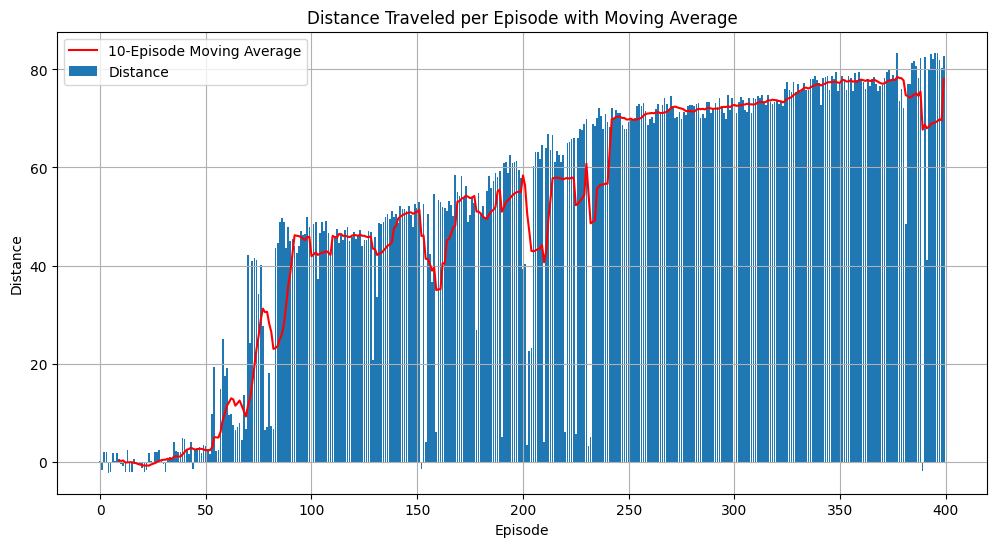

In [ ]:


import matplotlib.pyplot as plt
import numpy as np


# moving average - 10
window_size = 10
moving_average = np.convolve(lst_dist, np.ones(window_size), 'valid') / window_size

# bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(lst_dist)), lst_dist, label='Distance')

plt.plot(range(window_size - 1, len(lst_dist)), moving_average, color='red', label=f'{window_size}-Episode Moving Average')

plt.xlabel('Episode')
plt.ylabel('Distance')
plt.title('Distance Traveled per Episode with Moving Average')
plt.legend()
plt.grid(True)
plt.show()